# Tags Sentiment Analysis - 情感极性

## Dependencies

In [ ]:
!pip install ktrain
!pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import ktrain
import eli5
import jieba
from ktrain import text
import matplotlib.pyplot as plt
import pickle

## Data Preparation

In [2]:
data_train = pd.read_csv('datasets/train.csv')
data_test = pd.read_csv('datasets/test.csv')
data_val = pd.read_csv('datasets/dev.csv')

data_train.drop(['id', 'star'], axis=1, inplace=True)
data_val.drop(['id', 'star'], axis=1, inplace=True)
data_test.drop(['id', 'star'], axis=1, inplace=True)

In [3]:
#构建label值
def exist01(score):
    if score == 0: # 无明显情感倾向 
        return '0'
    else:
        return '1'

In [4]:
tag_list = [['Location#Transportation', 'Location#Downtown', 'Location#Easy_to_find'], 
            ['Service#Queue', 'Service#Hospitality', 'Service#Parking', 'Service#Timely'],
            ['Price#Level', 'Price#Cost_effective', 'Price#Discount'],
            ['Ambience#Decoration', 'Ambience#Noise', 'Ambience#Space', 'Ambience#Sanitary'],
            ['Food#Portion', 'Food#Taste', 'Food#Appearance', 'Food#Recommend']
            ]

for dataset in [data_train, data_val, data_test]:
    #-2转0
    dataset.replace(-2, 0, inplace=True)
    for l in tag_list:
        tmp = dataset[l].sum(axis=1)
        class_name = l[0].split('#')[0]
        print(class_name)
        dataset[class_name] = tmp.map(lambda x: exist01(x))
        print(dataset[class_name].value_counts())
        for cls in l:
            dataset.drop(cls, axis=1, inplace=True)

Location
0    23647
1    13203
Name: Location, dtype: int64
Service
1    20215
0    16635
Name: Service, dtype: int64
Price
0    20363
1    16487
Name: Price, dtype: int64
Ambience
1    18772
0    18078
Name: Ambience, dtype: int64
Food
1    27702
0     9148
Name: Food, dtype: int64
Location
0    3182
1    1758
Name: Location, dtype: int64
Service
1    2660
0    2280
Name: Service, dtype: int64
Price
0    2650
1    2290
Name: Price, dtype: int64
Ambience
1    2571
0    2369
Name: Ambience, dtype: int64
Food
1    3676
0    1264
Name: Food, dtype: int64
Location
0    3157
1    1783
Name: Location, dtype: int64
Service
1    2644
0    2296
Name: Service, dtype: int64
Price
0    2745
1    2195
Name: Price, dtype: int64
Ambience
1    2480
0    2460
Name: Ambience, dtype: int64
Food
1    3654
0    1286
Name: Food, dtype: int64


In [5]:
Location_train = data_train[['review', 'Location']]
Location_train = Location_train.dropna()
Location_val = data_val[['review', 'Location']]
Location_val = Location_val.dropna()
Location_test = data_test[['review', 'Location']]
Location_test = Location_test.dropna()

Service_train = data_train[['review', 'Service']]
Service_train = Service_train.dropna()
Service_val = data_val[['review', 'Service']]
Service_val = Service_val.dropna()
Service_test = data_test[['review', 'Service']]
Service_test = Service_test.dropna()

Price_train = data_train[['review', 'Price']]
Price_train = Price_train.dropna()
Price_val = data_val[['review', 'Price']]
Price_val = Price_val.dropna()
Price_test = data_test[['review', 'Price']]
Price_test = Price_test.dropna()

Ambience_train = data_train[['review', 'Ambience']]
Ambience_train = Ambience_train.dropna()
Ambience_val = data_val[['review', 'Ambience']]
Ambience_val = Ambience_val.dropna()
Ambience_test = data_test[['review', 'Ambience']]
Ambience_test = Ambience_test.dropna()

Food_train = data_train[['review', 'Food']]
Food_train = Food_train.dropna()
Food_val = data_val[['review', 'Food']]
Food_val = Food_val.dropna()
Food_test = data_test[['review', 'Food']]
Food_test = Food_test.dropna()

In [6]:
mask_pos = Location_train['Location'] == '1'

Location_train_pos = Location_train[mask_pos]

Location_train_oversamp = pd.concat([Location_train,Location_train_pos.sample(10000)], ignore_index=True)
Location_train_oversamp.iloc[: , 1:].value_counts()

Location
0           23647
1           23203
dtype: int64

In [7]:
mask_neg = Service_train['Service'] == '0'

Service_train_neg = Service_train[mask_neg]

Service_train_oversamp = pd.concat([Service_train,Service_train_neg.sample(4000)], ignore_index=True)
Service_train_oversamp.iloc[: , 1:].value_counts()

Service
0          20635
1          20215
dtype: int64

In [8]:
mask_pos = Price_train['Price'] == '1'

Price_train_pos = Price_train[mask_pos]

Price_train_oversamp = pd.concat([Price_train,Price_train_pos.sample(4000)], ignore_index=True)
Price_train_oversamp.iloc[: , 1:].value_counts()

Price
1        20487
0        20363
dtype: int64

In [9]:
Ambience_train.iloc[: , 1:].value_counts()

Ambience
1           18772
0           18078
dtype: int64

In [10]:
mask_neg = Food_train['Food'] == '0'

Food_train_neg = Food_train[mask_neg]

Food_train_oversamp = pd.concat([Food_train, Food_train_neg, Food_train_neg],ignore_index=True)
Food_train_oversamp.iloc[: , 1:].value_counts()

Food
1       27702
0       27444
dtype: int64

## LR

### Tokenization

In [40]:
#引入停用词
infile = open("stopwords-zh.txt",encoding='utf-8')
stopwords_lst = infile.readlines()
stopwords = [x.strip() for x in stopwords_lst]

#中文分词
def tokenization_dataset(train_data):
    tokenized_df = train_data.apply(lambda x:' '.join(jieba.cut(x)))
    return tokenized_df

def tokenization_text(text):
    tokenized_text = ' '.join(jieba.cut(text))
    return tokenized_text

In [41]:
x_Location_train = tokenization_dataset(Location_train['review'])
x_Service_train = tokenization_dataset(Service_train['review'])
x_Price_train = tokenization_dataset(Price_train['review'])
x_Ambience_train = tokenization_dataset(Ambience_train['review'])
x_Food_train = tokenization_dataset(Food_train['review'])

y_Location_train = Location_train['Location']
y_Service_train = Service_train['Service']
y_Price_train = Price_train['Price']
y_Ambience_train = Ambience_train['Ambience']
y_Food_train = Food_train['Food']

x_Location_val = tokenization_dataset(Location_val['review'])
x_Service_val = tokenization_dataset(Service_val['review'])
x_Price_val = tokenization_dataset(Price_val['review'])
x_Ambience_val = tokenization_dataset(Ambience_val['review'])
x_Food_val = tokenization_dataset(Food_val['review'])

y_Location_val = Location_val['Location']
y_Service_val = Service_val['Service']
y_Price_val = Price_val['Price']
y_Ambience_val = Ambience_val['Ambience']
y_Food_val = Food_val['Food']

x_Location_test = tokenization_dataset(Location_test['review'])
x_Service_test = tokenization_dataset(Service_test['review'])
x_Price_test = tokenization_dataset(Price_test['review'])
x_Ambience_test = tokenization_dataset(Ambience_test['review'])
x_Food_test = tokenization_dataset(Food_test['review'])

y_Location_test = Location_test['Location']
y_Service_test = Service_test['Service']
y_Price_test = Price_test['Price']
y_Ambience_test = Ambience_test['Ambience']
y_Food_test = Food_test['Food']

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
#使用tf-idf把文本转为向量
tv_1 = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv_2 = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv_3 = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv_4 = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv_5 = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)

tv_1.fit(x_Location_train)
tv_2.fit(x_Service_train)
tv_3.fit(x_Price_train)
tv_4.fit(x_Ambience_train)
tv_5.fit(x_Food_train)

TfidfVectorizer(lowercase=False, max_features=30000,
                stop_words=['$', '0', '1', '2', '3', '4', '5', '6', '7', '8',
                            '9', '?', '_', '“', '”', '、', '。', '《', '》', '一',
                            '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样',
                            '一般', '一转眼', ...])

In [80]:
# 保存模型
with open('LR_model_exist/tv_1_model.pickle', 'wb') as f:
    pickle.dump(tv_1, f)
    
with open('LR_model_exist/tv_2_model.pickle', 'wb') as f:
    pickle.dump(tv_2, f)
    
with open('LR_model_exist/tv_4_model.pickle', 'wb') as f:
    pickle.dump(tv_4, f)

### Train

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
model_Location = LogisticRegression(max_iter=10000)
model_Location.fit(tv_1.transform(x_Location_train), y_Location_train)
model_Location.score(tv_1.transform(x_Location_val), y_Location_val)

0.8481781376518218

In [45]:
model_Service = LogisticRegression(max_iter=10000)
model_Service.fit(tv_2.transform(x_Service_train), y_Service_train)
model_Service.score(tv_2.transform(x_Service_val), y_Service_val)

0.7520242914979757

In [46]:
model_Price = LogisticRegression(max_iter=10000)
model_Price.fit(tv_3.transform(x_Price_train), y_Price_train)
model_Price.score(tv_3.transform(x_Price_val), y_Price_val)

0.7659919028340081

In [47]:
model_Ambience = LogisticRegression(max_iter=10000)
model_Ambience.fit(tv_4.transform(x_Ambience_train), y_Ambience_train)
model_Ambience.score(tv_4.transform(x_Ambience_val), y_Ambience_val)

0.7963562753036437

In [48]:
model_Food = LogisticRegression(max_iter=10000)
model_Food.fit(tv_5.transform(x_Food_train), y_Food_train)
model_Food.score(tv_5.transform(x_Food_val), y_Food_val)

0.744331983805668

In [81]:
with open('LR_model_exist/model_Location_LR.pickle','wb') as f: 
    pickle.dump(model_Location,f) 
    
with open('LR_model_exist/model_Service_LR.pickle','wb') as f: 
    pickle.dump(model_Service,f) 

with open('LR_model_exist/model_Ambience_LR.pickle','wb') as f: 
    pickle.dump(model_Ambience,f) 

### Evaluation for LR Model

In [49]:
y_Location_pred = model_Location.predict(tv_1.transform(x_Location_test))
y_Service_pred = model_Service.predict(tv_2.transform(x_Service_test))
y_Price_pred = model_Price.predict(tv_3.transform(x_Price_test))
y_Ambience_pred = model_Ambience.predict(tv_4.transform(x_Ambience_test))
y_Food_pred = model_Food.predict(tv_5.transform(x_Food_test))

In [50]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Location_test, y_Location_pred))
print(classification_report(y_Service_test, y_Service_pred))
print(classification_report(y_Price_test, y_Price_pred))
print(classification_report(y_Ambience_test, y_Ambience_pred))
print(classification_report(y_Food_test, y_Food_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      3157
           1       0.88      0.65      0.75      1783

    accuracy                           0.84      4940
   macro avg       0.85      0.80      0.82      4940
weighted avg       0.85      0.84      0.84      4940

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      2296
           1       0.77      0.75      0.76      2644

    accuracy                           0.75      4940
   macro avg       0.74      0.75      0.74      4940
weighted avg       0.75      0.75      0.75      4940

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2745
           1       0.79      0.67      0.72      2195

    accuracy                           0.77      4940
   macro avg       0.78      0.76      0.77      4940
weighted avg       0.78      0.77      0.77      4940

              preci

In [51]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Location_test, y_Location_pred))
print(confusion_matrix(y_Service_test, y_Service_pred))
print(confusion_matrix(y_Price_test, y_Price_pred))
print(confusion_matrix(y_Ambience_test, y_Ambience_pred))
print(confusion_matrix(y_Food_test, y_Food_pred))

[[2997  160]
 [ 618 1165]]
[[1701  595]
 [ 663 1981]]
[[2361  384]
 [ 729 1466]]
[[2027  433]
 [ 592 1888]]
[[ 180 1106]
 [ 137 3517]]


In [52]:
def lr_explain(model, sentence, vec):
    return eli5.show_prediction(model, tokenization_text(sentence), vec=vec, feature_names=vec.get_feature_names_out())

In [53]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [54]:
display(lr_explain(model_Location, data_test['review'][53], tv_1))
display(lr_explain(model_Service, data_test['review'][53], tv_2))
display(lr_explain(model_Price, data_test['review'][53], tv_3))
display(lr_explain(model_Ambience, data_test['review'][53], tv_4))
display(lr_explain(model_Food, data_test['review'][53], tv_5))

In [55]:
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手aaa扶梯旁。'

In [56]:
display(lr_explain(model_Location, test1, tv_1))
display(lr_explain(model_Service, test1, tv_2))
display(lr_explain(model_Price, test1, tv_3))
display(lr_explain(model_Ambience, test1, tv_4))
display(lr_explain(model_Food, test1, tv_5))

In [57]:
display(lr_explain(model_Location, test2, tv_1))
display(lr_explain(model_Service, test2, tv_2))
display(lr_explain(model_Price, test2, tv_3))
display(lr_explain(model_Ambience, test2, tv_4))
display(lr_explain(model_Food, test2, tv_5))

In [58]:
display(lr_explain(model_Location, test3, tv_1))
display(lr_explain(model_Service, test3, tv_2))
display(lr_explain(model_Price, test3, tv_3))
display(lr_explain(model_Ambience, test3, tv_4))
display(lr_explain(model_Food, test3, tv_5))

## LR Oversampled

### Tokenization

In [59]:
#引入停用词
infile = open("stopwords-zh.txt",encoding='utf-8')
stopwords_lst = infile.readlines()
stopwords = [x.strip() for x in stopwords_lst]

#中文分词
def tokenization_dataset(train_data):
    tokenized_df = train_data.apply(lambda x:' '.join(jieba.cut(x)))
    return tokenized_df

def tokenization_text(text):
    tokenized_text = ' '.join(jieba.cut(text))
    return tokenized_text

In [60]:
x_Location_train_o = tokenization_dataset(Location_train_oversamp['review'])
x_Service_train_o = tokenization_dataset(Service_train_oversamp['review'])
x_Price_train_o = tokenization_dataset(Price_train_oversamp['review'])

x_Food_train_o = tokenization_dataset(Food_train_oversamp['review'])

y_Location_train_o = Location_train_oversamp['Location']
y_Service_train_o = Service_train_oversamp['Service']
y_Price_train_o = Price_train_oversamp['Price']

y_Food_train_o = Food_train_oversamp['Food']

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
#使用tf-idf把文本转为向量
tv_1_o = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv_2_o = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv_3_o = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)

tv_5_o = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)

tv_1_o.fit(x_Location_train_o)
tv_2_o.fit(x_Service_train_o)
tv_3_o.fit(x_Price_train_o)

tv_5_o.fit(x_Food_train_o)

TfidfVectorizer(lowercase=False, max_features=30000,
                stop_words=['$', '0', '1', '2', '3', '4', '5', '6', '7', '8',
                            '9', '?', '_', '“', '”', '、', '。', '《', '》', '一',
                            '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样',
                            '一般', '一转眼', ...])

In [83]:
# 保存模型
with open('LR_model_exist/tv_3_model.pickle', 'wb') as f:
    pickle.dump(tv_3_o, f)
    
with open('LR_model_exist/tv_5_model.pickle', 'wb') as f:
    pickle.dump(tv_5_o, f)

### Train

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
model_Location_o = LogisticRegression(max_iter=10000)
model_Location_o.fit(tv_1_o.transform(x_Location_train_o), y_Location_train_o)
model_Location_o.score(tv_1_o.transform(x_Location_val), y_Location_val)

0.8548582995951417

In [64]:
model_Service_o = LogisticRegression(max_iter=10000)
model_Service_o.fit(tv_2_o.transform(x_Service_train_o), y_Service_train_o)
model_Service_o.score(tv_2_o.transform(x_Service_val), y_Service_val)

0.7431174089068826

In [65]:
model_Price_o = LogisticRegression(max_iter=10000)
model_Price_o.fit(tv_3_o.transform(x_Price_train_o), y_Price_train_o)
model_Price_o.score(tv_3_o.transform(x_Price_val), y_Price_val)

0.7746963562753036

In [66]:
model_Food_o = LogisticRegression(max_iter=10000)
model_Food_o.fit(tv_5_o.transform(x_Food_train_o), y_Food_train_o)
model_Food_o.score(tv_5_o.transform(x_Food_val), y_Food_val)

0.6767206477732793

In [ ]:
with open('LR_model_exist/model_Price_LR.pickle','wb') as f: 
    pickle.dump(model_Price_o,f) 
    
with open('LR_model_exist/model_Food_LR.pickle','wb') as f: 
    pickle.dump(model_Food_o,f) 

### Evaluation for LR Model

In [67]:
y_Location_pred_o = model_Location_o.predict(tv_1_o.transform(x_Location_test))
y_Service_pred_o = model_Service_o.predict(tv_2_o.transform(x_Service_test))
y_Price_pred_o = model_Price_o.predict(tv_3_o.transform(x_Price_test))

y_Food_pred_o = model_Food_o.predict(tv_5_o.transform(x_Food_test))

In [68]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Location_test, y_Location_pred_o))
print(classification_report(y_Service_test, y_Service_pred_o))
print(classification_report(y_Price_test, y_Price_pred_o))
print(classification_report(y_Ambience_test, y_Ambience_pred))
print(classification_report(y_Food_test, y_Food_pred_o))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3157
           1       0.81      0.75      0.78      1783

    accuracy                           0.85      4940
   macro avg       0.84      0.83      0.83      4940
weighted avg       0.85      0.85      0.85      4940

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      2296
           1       0.78      0.69      0.73      2644

    accuracy                           0.73      4940
   macro avg       0.73      0.73      0.73      4940
weighted avg       0.74      0.73      0.73      4940

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2745
           1       0.77      0.73      0.75      2195

    accuracy                           0.78      4940
   macro avg       0.78      0.78      0.78      4940
weighted avg       0.78      0.78      0.78      4940

              preci

In [69]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Location_test, y_Location_pred_o))
print(confusion_matrix(y_Service_test, y_Service_pred_o))
print(confusion_matrix(y_Price_test, y_Price_pred_o))
print(confusion_matrix(y_Ambience_test, y_Ambience_pred))
print(confusion_matrix(y_Food_test, y_Food_pred_o))

[[2848  309]
 [ 445 1338]]
[[1787  509]
 [ 816 1828]]
[[2265  480]
 [ 595 1600]]
[[2027  433]
 [ 592 1888]]
[[ 765  521]
 [1100 2554]]


In [70]:
def lr_explain(model, sentence, vec):
    return eli5.show_prediction(model, tokenization_text(sentence), vec=vec, feature_names=vec.get_feature_names_out())

In [71]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [72]:
display(lr_explain(model_Location_o, data_test['review'][53], tv_1_o))
display(lr_explain(model_Service_o, data_test['review'][53], tv_2_o))
display(lr_explain(model_Price_o, data_test['review'][53], tv_3_o))
display(lr_explain(model_Ambience, data_test['review'][53], tv_4))
display(lr_explain(model_Food_o, data_test['review'][53], tv_5_o))

In [73]:
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手aaa扶梯旁。'

In [74]:
display(lr_explain(model_Location_o, test1, tv_1_o))
display(lr_explain(model_Service_o, test1, tv_2_o))
display(lr_explain(model_Price_o, test1, tv_3_o))
display(lr_explain(model_Ambience, test1, tv_4))
display(lr_explain(model_Food_o, test1, tv_5_o))

In [75]:
display(lr_explain(model_Location_o, test2, tv_1_o))
display(lr_explain(model_Service_o, test2, tv_2_o))
display(lr_explain(model_Price_o, test2, tv_3_o))
display(lr_explain(model_Ambience, test2, tv_4))
display(lr_explain(model_Food_o, test2, tv_5_o))

In [76]:
display(lr_explain(model_Location_o, test3, tv_1_o))
display(lr_explain(model_Service_o, test3, tv_2_o))
display(lr_explain(model_Price_o, test3, tv_3_o))
display(lr_explain(model_Ambience, test3, tv_4))
display(lr_explain(model_Food_o, test3, tv_5_o))

## Bert

### Location

#### Data Preparation and Tokenization

In [11]:
(x_Location_train_bert, y_Location_train_bert), (x_Location_val_bert, y_Location_val_bert), Location_preproc_bert = text.texts_from_df(
                                                                   train_df = Location_train,
                                                                   text_column = 'review',
                                                                   label_columns = 'Location',
                                                                   val_df = Location_val,
                                                                   max_features=30000,
                                                                   maxlen=256,
                                                                   preprocess_mode = 'bert')

['0', '1']
     0    1
0  0.0  1.0
1  0.0  1.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0
['0', '1']
     0    1
0  0.0  1.0
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


#### Model Preparation

In [16]:
Location_model_bert = text.text_classifier(name = 'bert',
                             train_data = (x_Location_train_bert, y_Location_train_bert),
                             preproc = Location_preproc_bert)

Is Multi-Label? False
maxlen is 256
done.


In [17]:
Location_learner_bert = ktrain.get_learner(model=Location_model_bert, train_data=(x_Location_train_bert, y_Location_train_bert),
                   val_data = (x_Location_val_bert, y_Location_val_bert),
                   batch_size = 16)

#### Train

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
2304/2304 [==============================] - 654s 277ms/step - loss: 0.4979 - accuracy: 0.7492
Epoch 2/2
2304/2304 [==============================] - 318s 138ms/step - loss: 2.0858 - accuracy: 0.5550


done.
Visually inspect loss plot and select learning rate associated with falling loss
Three possible suggestions for LR from plot:
	Longest valley (red): 5.19E-06
	Min numerical gradient (purple): 1.60E-07
	Min loss divided by 10 (omitted from plot): 1.97E-05


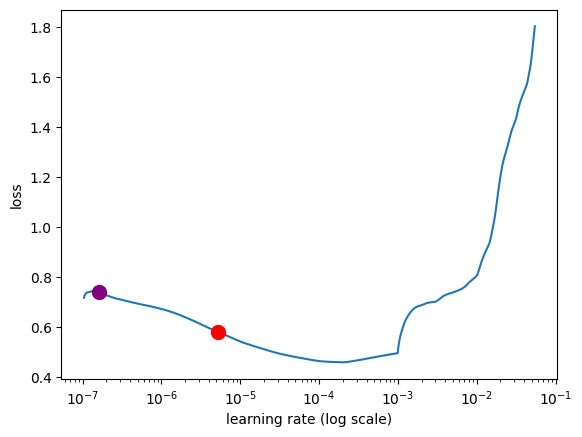

In [14]:
Location_learner_bert.lr_find(show_plot=True, suggest=True, max_epochs = 2)

In [18]:
Location_learner_bert.autofit(lr =5.60E-07, checkpoint_folder='bert-meituan-tags-exist/Location/tmp')
Location_predictor_bert = ktrain.get_predictor(Location_learner_bert.model, Location_preproc_bert)
Location_predictor_bert.save('bert-meituan-tags-exist/Location')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5.6e-07...
Epoch 1/1024
2304/2304 [==============================] - 728s 310ms/step - loss: 0.4969 - accuracy: 0.7462 - val_loss: 0.3581 - val_accuracy: 0.8474
Epoch 2/1024
2304/2304 [==============================] - 703s 305ms/step - loss: 0.3155 - accuracy: 0.8700 - val_loss: 0.3027 - val_accuracy: 0.8767
Epoch 3/1024
2304/2304 [==============================] - 719s 312ms/step - loss: 0.2836 - accuracy: 0.8875 - val_loss: 0.2945 - val_accuracy: 0.8812
Epoch 4/1024
2304/2304 [==============================] - 713s 310ms/step - loss: 0.2749 - accuracy: 0.8913 - val_loss: 0.2869 - val_accuracy: 0.8830
Epoch 5/1024
2304/2304 [==============================] - 718s 312ms/step - loss: 0.2669 - accuracy: 0.8928 - val_loss: 0.2828 - val_accuracy: 0.8846
Epoch 6/1024
2304/2304 [==============================] - 708s 3

#### Evaluation

In [19]:
x_Location_test_bert = Location_test['review']
y_Location_test_bert = Location_test['Location']
y_Location_pred_bert = Location_predictor_bert.predict(x_Location_test_bert.values)

In [20]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Location_test_bert, y_Location_pred_bert))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3157
           1       0.85      0.84      0.85      1783

    accuracy                           0.89      4940
   macro avg       0.88      0.88      0.88      4940
weighted avg       0.89      0.89      0.89      4940



In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Location_test_bert, y_Location_pred_bert))

[[2901  256]
 [ 281 1502]]


In [22]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [23]:
Location_predictor_bert.explain(data_test.iloc[53]['review'])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\revce\AppData\Local\Temp\jieba.cache
Loading model cost 0.538 seconds.
Prefix dict has been built successfully.


In [24]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星，搅屎棍
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [25]:
Location_predictor_bert.explain(test1)

In [26]:
Location_predictor_bert.explain(test2)

In [27]:
Location_predictor_bert.explain(test3)

### Service

#### Data Preparation and Tokenization

In [28]:
(x_Service_train_bert, y_Service_train_bert), (x_Service_val_bert, y_Service_val_bert), Service_preproc_bert = text.texts_from_df(
                                                                   train_df = Service_train,
                                                                   text_column = 'review',
                                                                   label_columns = 'Service',
                                                                   val_df = Service_val,
                                                                   max_features=30000,
                                                                   maxlen=256,
                                                                   preprocess_mode = 'bert')

['0', '1']
     0    1
0  0.0  1.0
1  0.0  1.0
2  0.0  1.0
3  1.0  0.0
4  1.0  0.0
['0', '1']
     0    1
0  1.0  0.0
1  0.0  1.0
2  1.0  0.0
3  0.0  1.0
4  0.0  1.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


#### Model Preparation

In [29]:
Service_model_bert = text.text_classifier(name = 'bert',
                             train_data = (x_Service_train_bert, y_Service_train_bert),
                             preproc = Service_preproc_bert)

Is Multi-Label? False
maxlen is 256
done.


In [30]:
Service_learner_bert = ktrain.get_learner(model=Service_model_bert, train_data=(x_Service_train_bert, y_Service_train_bert),
                   val_data = (x_Service_val_bert, y_Service_val_bert),
                   batch_size = 16)

#### Train

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
2304/2304 [==============================] - 649s 276ms/step - loss: 0.6272 - accuracy: 0.6360
Epoch 2/2
2304/2304 [==============================] - 338s 147ms/step - loss: 2.9227 - accuracy: 0.5030


done.
Visually inspect loss plot and select learning rate associated with falling loss
Three possible suggestions for LR from plot:
	Longest valley (red): 4.20E-06
	Min numerical gradient (purple): 1.00E-07
	Min loss divided by 10 (omitted from plot): 1.78E-05


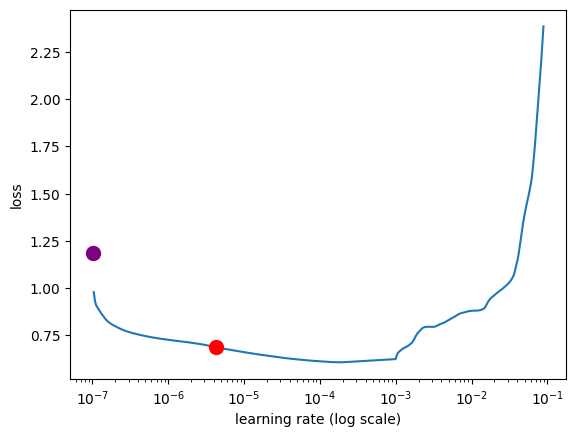

In [31]:
Service_learner_bert.lr_find(show_plot=True, suggest=True, max_epochs = 2)

In [32]:
Service_learner_bert.autofit(lr =6E-07, checkpoint_folder='bert-meituan-tags-exist/Service/tmp')
Service_predictor_bert = ktrain.get_predictor(Service_learner_bert.model, Service_preproc_bert)
Service_predictor_bert.save('bert-meituan-tags-exist/Service')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 6e-07...
Epoch 1/1024
2304/2304 [==============================] - 704s 299ms/step - loss: 0.6412 - accuracy: 0.6285 - val_loss: 0.5770 - val_accuracy: 0.7121
Epoch 2/1024
2304/2304 [==============================] - 727s 316ms/step - loss: 0.5393 - accuracy: 0.7356 - val_loss: 0.5342 - val_accuracy: 0.7460
Epoch 3/1024
2304/2304 [==============================] - 723s 314ms/step - loss: 0.5021 - accuracy: 0.7630 - val_loss: 0.5116 - val_accuracy: 0.7565
Epoch 4/1024
2304/2304 [==============================] - 713s 310ms/step - loss: 0.4832 - accuracy: 0.7721 - val_loss: 0.4979 - val_accuracy: 0.7660
Epoch 5/1024
2304/2304 [==============================] - 710s 308ms/step - loss: 0.4664 - accuracy: 0.7821 - val_loss: 0.4846 - val_accuracy: 0.7743
Epoch 6/1024
2304/2304 [==============================] - 713s 309

#### Evaluation

In [33]:
x_Service_test_bert = Service_test['review']
y_Service_test_bert = Service_test['Service']
y_Service_pred_bert = Service_predictor_bert.predict(x_Service_test_bert.values)

In [34]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Service_test_bert, y_Service_pred_bert))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      2296
           1       0.79      0.83      0.81      2644

    accuracy                           0.80      4940
   macro avg       0.80      0.79      0.79      4940
weighted avg       0.80      0.80      0.79      4940



In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Service_test_bert, y_Service_pred_bert))

[[1723  573]
 [ 438 2206]]


In [36]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [37]:
Service_predictor_bert.explain(data_test.iloc[53]['review'])

In [38]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星，搅屎棍
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [39]:
Service_predictor_bert.explain(test1)

In [40]:
Service_predictor_bert.explain(test2)

In [41]:
Service_predictor_bert.explain(test3)

### Price

#### Data Preparation and Tokenization

In [42]:
(x_Price_train_bert, y_Price_train_bert), (x_Price_val_bert, y_Price_val_bert), Price_preproc_bert = text.texts_from_df(
                                                                   train_df = Price_train,
                                                                   text_column = 'review',
                                                                   label_columns = 'Price',
                                                                   val_df = Price_val,
                                                                   max_features=30000,
                                                                   maxlen=256,
                                                                   preprocess_mode = 'bert')

['0', '1']
     0    1
0  1.0  0.0
1  1.0  0.0
2  1.0  0.0
3  0.0  1.0
4  0.0  1.0
['0', '1']
     0    1
0  1.0  0.0
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  0.0  1.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


#### Model Preparation

In [43]:
Price_model_bert = text.text_classifier(name = 'bert',
                             train_data = (x_Price_train_bert, y_Price_train_bert),
                             preproc = Price_preproc_bert)

Is Multi-Label? False
maxlen is 256
done.


In [44]:
Price_learner_bert = ktrain.get_learner(model=Price_model_bert, train_data=(x_Price_train_bert, y_Price_train_bert),
                   val_data = (x_Price_val_bert, y_Price_val_bert),
                   batch_size = 16)

#### Train

In [46]:
Price_learner_bert.lr_find(show_plot=True, suggest=True, max_epochs = 5)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
  89/2304 [>.............................] - ETA: 8:53 - loss: 0.7346 - accuracy: 0.5442

In [47]:
Price_learner_bert.autofit(lr =6E-07, checkpoint_folder='bert-meituan-tags-exist/Price/tmp')
Price_predictor_bert = ktrain.get_predictor(Price_learner_bert.model, Price_preproc_bert)
Price_predictor_bert.save('bert-meituan-tags-exist/Price')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 6e-07...
Epoch 1/1024
2304/2304 [==============================] - 691s 294ms/step - loss: 0.6570 - accuracy: 0.6112 - val_loss: 0.5902 - val_accuracy: 0.7026
Epoch 2/1024
2304/2304 [==============================] - 690s 299ms/step - loss: 0.5313 - accuracy: 0.7476 - val_loss: 0.5126 - val_accuracy: 0.7654
Epoch 3/1024
2304/2304 [==============================] - 674s 293ms/step - loss: 0.4887 - accuracy: 0.7786 - val_loss: 0.4987 - val_accuracy: 0.7731
Epoch 4/1024
2304/2304 [==============================] - 671s 291ms/step - loss: 0.4696 - accuracy: 0.7887 - val_loss: 0.4860 - val_accuracy: 0.7773
Epoch 5/1024
2304/2304 [==============================] - 667s 289ms/step - loss: 0.4565 - accuracy: 0.7959 - val_loss: 0.4765 - val_accuracy: 0.7796
Epoch 6/1024
2304/2304 [==============================] - 668s 290

#### Evaluation

In [48]:
x_Price_test_bert = Price_test['review']
y_Price_test_bert = Price_test['Price']
y_Price_pred_bert = Price_predictor_bert.predict(x_Price_test_bert.values)

In [49]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Price_test_bert, y_Price_pred_bert))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2745
           1       0.78      0.78      0.78      2195

    accuracy                           0.80      4940
   macro avg       0.80      0.80      0.80      4940
weighted avg       0.80      0.80      0.80      4940



In [50]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Price_test_bert, y_Price_pred_bert))

[[2271  474]
 [ 492 1703]]


In [51]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [52]:
Price_predictor_bert.explain(data_test.iloc[53]['review'])

In [53]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星，搅屎棍
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [54]:
Price_predictor_bert.explain(test1)

In [55]:
Price_predictor_bert.explain(test2)

In [56]:
Price_predictor_bert.explain(test3)

### Ambience

#### Data Preparation and Tokenization

In [57]:
(x_Ambience_train_bert, y_Ambience_train_bert), (x_Ambience_val_bert, y_Ambience_val_bert), Ambience_preproc_bert = text.texts_from_df(
                                                                   train_df = Ambience_train,
                                                                   text_column = 'review',
                                                                   label_columns = 'Ambience',
                                                                   val_df = Ambience_val,
                                                                   max_features=30000,
                                                                   maxlen=256,
                                                                   preprocess_mode = 'bert')

['0', '1']
     0    1
0  0.0  1.0
1  0.0  1.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0
['0', '1']
     0    1
0  1.0  0.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  1.0  0.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


#### Model Preparation

In [61]:
Ambience_model_bert = text.text_classifier(name = 'bert',
                             train_data = (x_Ambience_train_bert, y_Ambience_train_bert),
                             preproc = Ambience_preproc_bert)

Is Multi-Label? False
maxlen is 256
done.


In [62]:
Ambience_learner_bert = ktrain.get_learner(model=Ambience_model_bert, train_data=(x_Ambience_train_bert, y_Ambience_train_bert),
                   val_data = (x_Ambience_val_bert, y_Ambience_val_bert),
                   batch_size = 16)

#### Train

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
2304/2304 [==============================] - 633s 268ms/step - loss: 0.5725 - accuracy: 0.6815
Epoch 2/2
2304/2304 [==============================] - 298s 129ms/step - loss: 2.5740 - accuracy: 0.5005


done.
Visually inspect loss plot and select learning rate associated with falling loss
Three possible suggestions for LR from plot:
	Longest valley (red): 4.22E-06
	Min numerical gradient (purple): 1.00E-07
	Min loss divided by 10 (omitted from plot): 1.77E-05


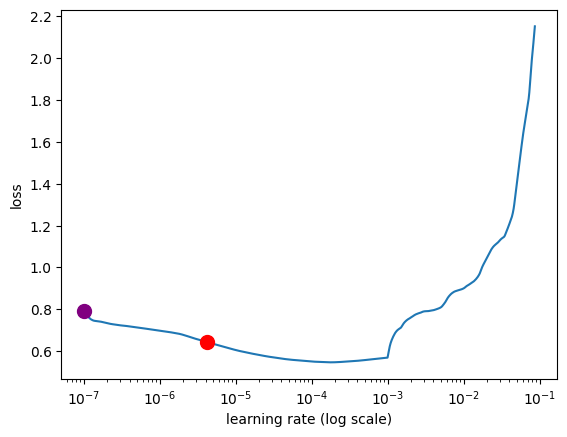

In [63]:
Ambience_learner_bert.lr_find(show_plot=True, suggest=True, max_epochs = 2)

In [64]:
Ambience_learner_bert.autofit(lr =6E-07, checkpoint_folder='bert-meituan-tags-exist/Ambience/tmp')
Ambience_predictor_bert = ktrain.get_predictor(Ambience_learner_bert.model, Ambience_preproc_bert)
Ambience_predictor_bert.save('bert-meituan-tags-exist/Ambience')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 6e-07...
Epoch 1/1024
2304/2304 [==============================] - 651s 276ms/step - loss: 0.5808 - accuracy: 0.6805 - val_loss: 0.4779 - val_accuracy: 0.7895
Epoch 2/1024
2304/2304 [==============================] - 649s 282ms/step - loss: 0.4443 - accuracy: 0.8059 - val_loss: 0.4204 - val_accuracy: 0.8132
Epoch 3/1024
2304/2304 [==============================] - 648s 281ms/step - loss: 0.4078 - accuracy: 0.8205 - val_loss: 0.3991 - val_accuracy: 0.8221
Epoch 4/1024
2304/2304 [==============================] - 647s 281ms/step - loss: 0.3903 - accuracy: 0.8316 - val_loss: 0.3900 - val_accuracy: 0.8296
Epoch 5/1024
2304/2304 [==============================] - 647s 281ms/step - loss: 0.3789 - accuracy: 0.8386 - val_loss: 0.3850 - val_accuracy: 0.8312
Epoch 6/1024
2304/2304 [==============================] - 646s 280

#### Evaluation

In [65]:
x_Ambience_test_bert = Ambience_test['review']
y_Ambience_test_bert = Ambience_test['Ambience']
y_Ambience_pred_bert = Ambience_predictor_bert.predict(x_Ambience_test_bert.values)

In [66]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Ambience_test_bert, y_Ambience_pred_bert))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2460
           1       0.82      0.86      0.84      2480

    accuracy                           0.84      4940
   macro avg       0.84      0.84      0.84      4940
weighted avg       0.84      0.84      0.84      4940



In [67]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Ambience_test_bert, y_Ambience_pred_bert))

[[2003  457]
 [ 336 2144]]


In [68]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [69]:
Ambience_predictor_bert.explain(data_test.iloc[53]['review'])

In [70]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星，搅屎棍
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [71]:
Ambience_predictor_bert.explain(test1)

In [72]:
Ambience_predictor_bert.explain(test2)

In [73]:
Ambience_predictor_bert.explain(test3)

### Food

#### Data Preparation and Tokenization

In [74]:
(x_Food_train_bert, y_Food_train_bert), (x_Food_val_bert, y_Food_val_bert), Food_preproc_bert = text.texts_from_df(
                                                                   train_df = Food_train,
                                                                   text_column = 'review',
                                                                   label_columns = 'Food',
                                                                   val_df = Food_val,
                                                                   max_features=30000,
                                                                   maxlen=256,
                                                                   preprocess_mode = 'bert')

['0', '1']
     0    1
0  0.0  1.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
['0', '1']
     0    1
0  1.0  0.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


#### Model Preparation

In [75]:
Food_model_bert = text.text_classifier(name = 'bert',
                             train_data = (x_Food_train_bert, y_Food_train_bert),
                             preproc = Food_preproc_bert)

Is Multi-Label? False
maxlen is 256
done.


In [76]:
Food_learner_bert = ktrain.get_learner(model=Food_model_bert, train_data=(x_Food_train_bert, y_Food_train_bert),
                   val_data = (x_Food_val_bert, y_Food_val_bert),
                   batch_size = 16)

#### Train

In [ ]:
Food_learner_bert.lr_find(show_plot=True, suggest=True, max_epochs = 2)

In [77]:
Food_learner_bert.autofit(lr =6E-07, checkpoint_folder='bert-meituan-tags-exist/Food/tmp')
Food_predictor_bert = ktrain.get_predictor(Food_learner_bert.model, Food_preproc_bert)
Food_predictor_bert.save('bert-meituan-tags-exist/Food')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 6e-07...
Epoch 1/1024
2304/2304 [==============================] - 658s 279ms/step - loss: 0.5680 - accuracy: 0.7231 - val_loss: 0.5233 - val_accuracy: 0.7395
Epoch 2/1024
2304/2304 [==============================] - 639s 277ms/step - loss: 0.5041 - accuracy: 0.7531 - val_loss: 0.5049 - val_accuracy: 0.7445
Epoch 3/1024
2304/2304 [==============================] - 636s 276ms/step - loss: 0.4906 - accuracy: 0.7559 - val_loss: 0.4963 - val_accuracy: 0.7470
Epoch 4/1024
2304/2304 [==============================] - 627s 272ms/step - loss: 0.4792 - accuracy: 0.7623 - val_loss: 0.4875 - val_accuracy: 0.7496
Epoch 5/1024
2304/2304 [==============================] - 635s 276ms/step - loss: 0.4679 - accuracy: 0.7680 - val_loss: 0.4786 - val_accuracy: 0.7565
Epoch 6/1024
2304/2304 [==============================] - 637s 276

#### Evaluation

In [78]:
x_Food_test_bert = Food_test['review']
y_Food_test_bert = Food_test['Food']
y_Food_pred_bert = Food_predictor_bert.predict(x_Food_test_bert.values)

In [79]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Food_test_bert, y_Food_pred_bert))

              precision    recall  f1-score   support

           0       0.57      0.43      0.49      1286
           1       0.82      0.89      0.85      3654

    accuracy                           0.77      4940
   macro avg       0.69      0.66      0.67      4940
weighted avg       0.75      0.77      0.76      4940



In [80]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Food_test_bert, y_Food_pred_bert))

[[ 549  737]
 [ 407 3247]]


In [81]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [82]:
Food_predictor_bert.explain(data_test.iloc[53]['review'])

In [83]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星，搅屎棍
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [84]:
Food_predictor_bert.explain(test1)

In [85]:
Food_predictor_bert.explain(test2)

In [86]:
Food_predictor_bert.explain(test3)

### Food Oversampled

#### Data Preparation and Tokenization

In [11]:
(x_Food_train_bert_o, y_Food_train_bert_o), (x_Food_val_bert, y_Food_val_bert), Food_preproc_bert_o = text.texts_from_df(
                                                                   train_df = Food_train_oversamp,
                                                                   text_column = 'review',
                                                                   label_columns = 'Food',
                                                                   val_df = Food_val,
                                                                   max_features=30000,
                                                                   maxlen=256,
                                                                   preprocess_mode = 'bert')

['0', '1']
     0    1
0  0.0  1.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
['0', '1']
     0    1
0  1.0  0.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


#### Model Preparation

In [20]:
Food_model_bert_o = text.text_classifier(name = 'bert',
                             train_data = (x_Food_train_bert_o, y_Food_train_bert_o),
                             preproc = Food_preproc_bert_o)

Is Multi-Label? False
maxlen is 256
done.


In [21]:
Food_learner_bert_o = ktrain.get_learner(model=Food_model_bert_o, train_data=(x_Food_train_bert_o, y_Food_train_bert_o),
                   val_data = (x_Food_val_bert, y_Food_val_bert),
                   batch_size = 16)

#### Train

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
3447/3447 [==============================] - 907s 259ms/step - loss: 0.6549 - accuracy: 0.6008
Epoch 2/2
3447/3447 [==============================] - 460s 133ms/step - loss: 2.8571 - accuracy: 0.5017


done.
Visually inspect loss plot and select learning rate associated with falling loss
Three possible suggestions for LR from plot:
	Longest valley (red): 3.80E-06
	Min numerical gradient (purple): 1.06E-07
	Min loss divided by 10 (omitted from plot): 1.28E-05


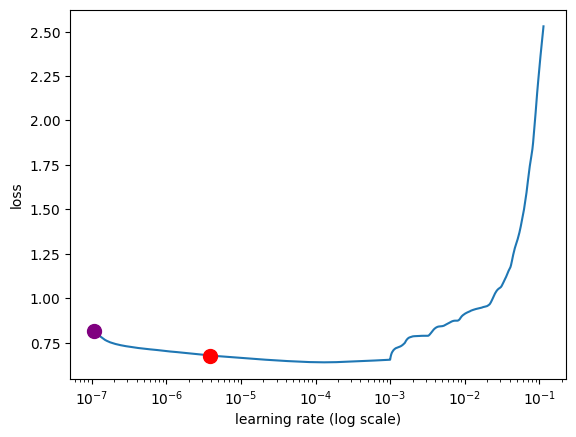

In [14]:
Food_learner_bert_o.lr_find(show_plot=True, suggest=True, max_epochs = 2)

In [23]:
Food_learner_bert_o.autofit(lr=8E-07, checkpoint_folder='bert-meituan-tags-exist/Food_o/tmp')
Food_predictor_bert_o = ktrain.get_predictor(Food_learner_bert_o.model, Food_preproc_bert_o)
Food_predictor_bert_o.save('bert-meituan-tags-exist/Food_o')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 8e-07...
Epoch 1/1024
  29/3447 [..............................] - ETA: 13:21 - loss: 0.4617 - accuracy: 0.7716

KeyboardInterrupt: 

#### Evaluation

In [26]:
x_Food_test_bert = Food_test['review']
y_Food_test_bert = Food_test['Food']
y_Food_pred_bert_o = Food_predictor_bert_o.predict(x_Food_test_bert.values)

In [27]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_Food_test_bert, y_Food_pred_bert_o))

              precision    recall  f1-score   support

           0       0.48      0.75      0.59      1286
           1       0.89      0.71      0.79      3654

    accuracy                           0.72      4940
   macro avg       0.69      0.73      0.69      4940
weighted avg       0.78      0.72      0.74      4940



In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_Food_test_bert, y_Food_pred_bert_o))

[[ 970  316]
 [1054 2600]]


In [29]:
data_test.iloc[53]

review      虽然就在家附近，但很久没有来明记吃饭了。因为附近太多选择，什么上渡食家，凤厨等等这些比较出名...
Location                                                    0
Service                                                     1
Price                                                       1
Ambience                                                    1
Food                                                        1
Name: 53, dtype: object

In [30]:
Food_predictor_bert_o.explain(data_test.iloc[53]['review'])

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\revce\AppData\Local\Temp\jieba.cache
Loading model cost 0.580 seconds.
Prefix dict has been built successfully.


In [31]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星，搅屎棍
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [32]:
Food_predictor_bert_o.explain(test1)

In [33]:
Food_predictor_bert_o.explain(test2)

In [34]:
Food_predictor_bert_o.explain(test3)